## Part 5

### imports

In [2]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 44.3 MB/s eta 0:00:00


In [3]:
from gurobipy import GRB
import gurobipy as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

### Data organizing

In [4]:
path2019 = 'https://raw.githubusercontent.com/AHMerrill/optimization_1/main/stocks2019.csv'
path2020 = 'https://raw.githubusercontent.com/AHMerrill/optimization_1/main/stocks2020.csv'

def load_stock_csv(path):
    df = pd.read_csv(path)
    # Always rename the first column to 'date'
    first_col = df.columns[0]
    df = df.rename(columns={first_col: "date"})
    # Parse to datetime and set as index
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")
    return df

s19 = load_stock_csv(path2019)
s20 = load_stock_csv(path2020)

# Daily returns
r19 = s19.pct_change(1).iloc[1:]
r20 = s20.pct_change(1).iloc[1:]

# Drop NDX from both
r19nondx = r19.drop(columns=["NDX"])
r20nondx = r20.drop(columns=["NDX"])

# Keep only common tickers
common_cols = r19nondx.columns.intersection(r20nondx.columns)
r19nondx = r19nondx[common_cols]
r20nondx = r20nondx[common_cols]

# Combined daily returns
r_all = pd.concat([r19nondx, r20nondx], axis=0).sort_index()


/tmp/ipython-input-1596500279.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["date"])


In [5]:
r_all

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.035509,-0.039498,-0.094530,0.022030,-0.085791,-0.027696,-0.028484,-0.025242,-0.015216,-0.060405,...,-0.022834,-0.018591,-0.034989,-0.030557,-0.002133,-0.010435,-0.035808,-0.068217,-0.003940,-0.037651
2019-01-04,0.039903,0.048632,0.114370,0.057779,0.010445,0.051294,0.053786,0.050064,0.034184,0.024278,...,0.058976,0.047954,0.044744,0.044147,0.054785,0.033269,0.060577,0.042356,0.009786,0.046303
2019-01-07,0.028196,0.013573,0.082632,0.018302,0.017192,-0.001994,-0.002167,0.034353,0.013457,0.006288,...,0.022067,0.062620,0.016312,0.001000,0.018240,0.005749,0.000918,0.035522,-0.004330,0.026415
2019-01-08,0.030309,0.014918,0.008751,0.006207,0.015954,0.008783,0.007385,0.016612,0.012824,0.024396,...,0.010281,0.018450,0.036460,0.008902,0.013307,0.020009,0.021101,-0.009615,0.011597,-0.019051
2019-01-09,0.017210,0.011819,-0.026988,0.012430,0.038196,-0.003427,-0.001505,0.001714,-0.001196,0.025340,...,0.023745,0.018804,-0.008157,0.003781,0.023065,0.012050,-0.004612,0.044083,-0.007984,0.008972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.008835,-0.014400,-0.017282,-0.003706,-0.021599,0.004656,0.005152,-0.006627,0.008824,-0.007347,...,-0.009712,0.012713,-0.010770,-0.009706,0.004002,0.015279,-0.034729,0.004224,-0.008021,-0.015053
2020-12-24,0.008314,0.005937,0.002840,-0.003981,0.005771,0.003431,0.003735,-0.003949,-0.000045,0.008728,...,-0.019614,-0.014229,0.002710,0.006301,-0.005851,-0.006270,0.000000,-0.000200,0.004976,0.000000
2020-12-28,0.005167,-0.001820,-0.002287,0.011335,-0.013579,0.022951,0.021416,0.035071,0.003230,0.001454,...,-0.002813,0.051126,0.010299,0.033544,-0.008488,0.001010,-0.027496,0.002805,0.010676,-0.003310


### Create a "lookback" function that can handle multiple time windows
#### This creates a dictionary of data frames that are called by "keys" which are the months we're planning for.  This will be a part of the loop gurobi optimizes through later

In [ ]:
def make_monthly_lookbacks_calendar(rets: pd.DataFrame, target_year: int = 2020):
    """
    Build rolling lookbacks using actual trading days from `rets`:
      '2020-03' -> first trading day on/after 2019-03-01
       to the
      last trading day before 2020-03-01

      This creates a dictionary of dataFrames
    """
    out = {}
    months = pd.period_range(f'{target_year}-01', f'{target_year}-12', freq='M')

    # convenience: the DatetimeIndex as a numpy array for fast lookups
    idx = rets.index

    for p in months:
        month_start = p.start_time  # e.g., Timestamp('2020-03-01')

        # 1) lb_end = last trading day strictly before the month starts
        #    (assumes you have data covering prior year)
        lb_end = idx[idx < month_start][-1]

        # 2) lb_start_candidate = one year earlier (calendar), then snap to the FIRST trading day
        #    on/after that calendar date so holidays/weekends are respected.
        lb_start_candidate = month_start - pd.DateOffset(years=1)
        # find first index >= lb_start_candidate
        lb_start = idx[idx >= lb_start_candidate][0]

        # 3) slice and drop rows with any missing stocks
        win = rets.loc[lb_start:lb_end].dropna()

        out[p.strftime('%Y-%m')] = win

    return out

lookbacks_2020 = make_monthly_lookbacks_calendar(r_all, target_year=2020)

# sanity check: uncomment to view keys and shape of each data frame
# for m, df in lookbacks_2020.items():
#     print(m, df.index.min().date(), "→", df.index.max().date(), df.shape)


In [ ]:
# when you want to set one window, you pick the forward month
# for example, this will return:
# first trading day of march 2019
# to last trading day of feb 2020

# Uncomment to view example
# display(lookbacks_2020['2020-03'].head(2))
# display(lookbacks_2020['2020-03'].tail(2))

### Helper Functions

#### Decision variables: This helps build the decision variables for each rolling window

In [ ]:
def init_cvar_decision_vars(window_rets: pd.DataFrame, allow_short: bool = False, quiet: bool = True):
    """
    Build a fresh model for one rolling window.
    Vars:
      x      (N,)  portfolio weights
      alpha         VaR threshold (scalar)
      u      (S,)  tail slacks, one per scenario/day  (MVar)
    """
    # Ensure predictable ordering
    tickers = list(window_rets.columns)
    S, N = window_rets.shape

    # Dense float arrays for Gurobi
    r = window_rets.values.astype(float)            # (S, N)
    mu = window_rets.mean(axis=0).values.astype(float)  # (N,)

    m = gp.Model("cvar_month")
    if quiet:
        m.Params.OutputFlag = 0  # quiet by default

    lb = -GRB.INFINITY if allow_short else 0.0
    ub = GRB.INFINITY  if allow_short else 1.0

    # Decision variables
    x = m.addMVar(N, lb=lb, ub=ub, name="x")            # weights
    alpha = m.addVar(lb=-GRB.INFINITY, name="alpha")    # VaR
    u = m.addMVar(S, lb=0.0, name="u")                  # tail slacks (vector)

    data = {"S": S, "N": N, "tickers": tickers, "r": r, "mu": mu}
    return m, x, alpha, u, data


#### Helps build objectives and constraints for each rolling window

In [ ]:
def add_cvar_objective_and_constraints(
    m, x, alpha, u, data,
    beta: float = 0.95,
    R_floor: float | None = 0.0002
):
    """
    Adds:
      - Tail constraints: u + alpha >= losses, where losses = -(r @ x)   (vectorized & Gurobi-safe)
      - Budget: sum(x) = 1
      - Optional return floor: mu @ x >= R_floor
      - Objective: alpha + (1/((1-beta)*S)) * sum(u)
    """
    S = data["S"]
    r = data["r"]   # shape (S, N)
    mu = data["mu"] # shape (N,)

    # Vectorized losses across all scenarios
    losses = - (r @ x)  # length-S MVar

    # Tail constraints (move alpha to LHS to avoid NumPy/Gurobi type issues)
    m.addConstr(u + alpha >= losses, name="tail_all")

    # Budget
    m.addConstr(x.sum() == 1.0, name="budget")

    # Optional expected-return floor
    if R_floor is not None:
        m.addConstr(mu @ x >= R_floor, name="return_floor")

    # Objective (Rockafellar–Uryasev)
    inv_tail_mass = 1.0 / ((1.0 - beta) * S)
    m.setObjective(alpha + inv_tail_mass * u.sum(), GRB.MINIMIZE)


#### Defines losses for each rolling window

##### Note: this is to determine out of sample losses and the NDX evaluation.  It's formulated as a kind of "mini-optimization" problem where the weights will be set (either weights calculated or 1.0 if looking at NDX).  This is done this way to have an apples-to-apples comparison to our in-sample setup

In [ ]:
def cvar_lp_on_losses_series(losses: pd.Series, beta: float = 0.95, quiet: bool = True):
    """
    LP-based VaR/CVaR on a *loss* series (losses = -returns).
    Returns (VaR, CVaR) using the Rockafellar–Uryasev formulation.
    """
    L = losses.dropna().to_numpy(dtype=float)
    S = len(L)

    m = gp.Model("cvar_eval_oos")
    if quiet:
        m.Params.OutputFlag = 0

    alpha = m.addVar(lb=-GRB.INFINITY, name="alpha")
    u = m.addMVar(S, lb=0.0, name="u")

    # Tail constraints (safe form): u + alpha >= L
    m.addConstr(u + alpha >= L, name="tail_all")

    # Objective
    m.setObjective(alpha + (1/((1 - beta) * S)) * u.sum(), GRB.MINIMIZE)

    m.optimize()
    return float(alpha.X), float(m.objVal)


### Full optimization setup: This loop will loop over the dictionary of dataframes and evaluate weights, then determine portfolio performance and benchmark (NDX) performance for those same periods

In [ ]:
# === Rolling CVaR loop with LP-based OOS CVaR and NDX summary ===

beta = 0.95
R_floor = 0.0002   # daily 0.02%; set None to remove the ER floor
allow_short = False

months = sorted(lookbacks_2020.keys())      # ['2020-01', ..., '2020-12']
master_tickers = list(r_all.columns)        # stable column order for the weights table

weights_rows, ins_rows, oos_rows = [], [], []
oos_daily_returns_list = []  # NEW ↓ collect daily OOS returns across 2020

for month_key in months:
    # --- In-sample: optimize on the prior 12-month trading window
    df_win = lookbacks_2020[month_key]
    m, x, alpha, u, data = init_cvar_decision_vars(df_win, allow_short=allow_short)
    add_cvar_objective_and_constraints(m, x, alpha, u, data, beta=beta, R_floor=R_floor)
    m.optimize()

    # Weights aligned to a fixed column order
    w = pd.Series(x.X, index=data["tickers"], name=month_key)
    w = w.reindex(master_tickers).fillna(0.0)
    weights_rows.append(w)

    # In-sample metrics (simple names)
    ins_rows.append({
        "Month": month_key,
        "In_Days": int(df_win.shape[0]),
        "In_VaR": float(alpha.X),
        "In_CVaR": float(m.objVal),  # optimized CVaR objective
        "In_MeanRet": float(df_win.mean() @ w.loc[df_win.columns]),
    })

    # --- Out-of-sample: realized stats in the *target* month (LP CVaR)
    p = pd.Period(month_key, freq='M')
    Rm = r_all.loc[p.start_time:p.end_time][w.index].dropna(how='any')  # realized daily returns in that month
    port_ret = Rm @ w
    oos_daily_returns_list.append(port_ret)  # NEW ↓ keep daily OOS returns

    losses = -port_ret
    oos_var_lp, oos_cvar_lp = cvar_lp_on_losses_series(losses, beta=beta, quiet=True)

    oos_rows.append({
        "Month": month_key,
        "OOS_Days": int(Rm.shape[0]),
        "OOS_VaR": oos_var_lp,
        "OOS_CVaR": oos_cvar_lp,
        "OOS_MeanRet": float(port_ret.mean()),
        "OOS_CumRet": float((1 + port_ret).prod() - 1),
    })

# Assemble outputs
weights_df = pd.DataFrame(weights_rows)                 # rows = months, cols = tickers
weights_df.index.name = "Month"

ins_df  = pd.DataFrame(ins_rows).set_index("Month").sort_index()
oos_df  = pd.DataFrame(oos_rows).set_index("Month").sort_index()

# Compact side-by-side table with paired columns (In_* next to OOS_*)
compact_cols = [
    "In_Days",  "OOS_Days",
    "In_VaR",   "OOS_VaR",
    "In_CVaR",  "OOS_CVaR",
    "In_MeanRet","OOS_MeanRet",
]
compact_df = (
    ins_df.join(oos_df, how="left")
          .reindex(months)     # keep month order
          .reindex(columns=compact_cols + ["OOS_CumRet"])  # cumulative OOS return at the end
)

# ----- NEW: OOS monthly total return table (plus YTD roll-up) -----
oos_total_df = pd.DataFrame({
    "OOS_Total_Return": compact_df["OOS_CumRet"],
})
oos_total_df["Growth_of_$1"] = 1.0 + oos_total_df["OOS_Total_Return"]
oos_total_df["YTD_Growth_of_$1"] = oos_total_df["Growth_of_$1"].cumprod()
oos_total_df["YTD_Total_Return"] = oos_total_df["YTD_Growth_of_$1"] - 1.0

# ----- NEW: OOS daily equity path across 2020 -----
oos_daily_rets_2020 = pd.concat(oos_daily_returns_list).sort_index()
oos_daily_path_df = pd.DataFrame({
    "OOS_Daily_Return": oos_daily_rets_2020,
})
oos_daily_path_df["OOS_Equity"] = (1.0 + oos_daily_path_df["OOS_Daily_Return"]).cumprod()
# (Optional) final number should match product of monthly Growth_of_$1
# float(oos_daily_path_df["OOS_Equity"].iloc[-1] - 1.0)

# ----- CVaR summary stats (In vs OOS) -----
cvar_summary_df = pd.DataFrame({
    "In_Avg_CVaR":   [compact_df["In_CVaR"].mean()],
    "In_Std_CVaR":   [compact_df["In_CVaR"].std(ddof=1)],
    "In_Max_CVaR":   [compact_df["In_CVaR"].max()],
    "In_Min_CVaR":   [compact_df["In_CVaR"].min()],
    "OOS_Avg_CVaR":  [compact_df["OOS_CVaR"].mean()],
    "OOS_Std_CVaR":  [compact_df["OOS_CVaR"].std(ddof=1)],
    "OOS_Max_CVaR":  [compact_df["OOS_CVaR"].max()],
    "OOS_Min_CVaR":  [compact_df["OOS_CVaR"].min()],
}).T
cvar_summary_df.columns = ["Value"]

# ----- NDX (Nasdaq) summary, LP CVaR on full 2020 -----
ndx_rets_all = pd.concat([r19["NDX"], r20["NDX"]]).sort_index()
ndx_2020 = ndx_rets_all.loc["2020"].dropna()
ndx_losses_2020 = -ndx_2020
ndx_var_lp, ndx_cvar_lp = cvar_lp_on_losses_series(ndx_losses_2020, beta=beta, quiet=True)

ndx_summary_df = pd.DataFrame({
    "NDX_VaR": [ndx_var_lp],
    "NDX_CVaR": [ndx_cvar_lp],
    "NDX_Avg_Daily_Return": [ndx_2020.mean()],
    "NDX_Total_Return": [(1 + ndx_2020).prod() - 1],
}).T
ndx_summary_df.columns = ["NDX_2020"]

# Optional: trimmed weights view (only show weights > 1% abs)
nontrivial_weights_df = (
    weights_df.where(weights_df.abs() > 0.01)
              .dropna(axis=1, how="all")
              .fillna(0.0)
)

# === Displays ===
from IPython.display import display
display(compact_df.round(6))              # paired In vs OOS by month
display(oos_total_df.round(6))            # NEW: monthly OOS total returns (with YTD)
display(oos_daily_path_df.tail(10).round(6))  # NEW: last 10 rows of daily equity path
display(cvar_summary_df.round(6))         # CVaR avg/std/min/max for In & OOS
display(ndx_summary_df.round(6))          # NDX LP CVaR & returns (2020 full year)
display(nontrivial_weights_df.round(4))   # readable weights (use weights_df to see all)


Restricted license - for non-production use only - expires 2026-11-23


,In_Days,OOS_Days,In_VaR,OOS_VaR,In_CVaR,OOS_CVaR,In_MeanRet,OOS_MeanRet,OOS_CumRet
Month,,,,,,,,,
2020-01,250,20,0.008500,0.008140,0.011090,0.008140,0.001227,0.002266,0.046035
2020-02,250,19,0.008511,0.035750,0.011024,0.035750,0.001061,-0.004170,-0.077673
2020-03,250,22,0.011184,0.074807,0.014841,0.101232,0.000788,-0.000283,-0.033243
2020-04,251,21,0.018740,0.033241,0.029922,0.041765,0.001207,0.007185,0.154878
2020-05,251,20,0.021535,0.029995,0.031384,0.029995,0.001218,0.003404,0.067821
2020-06,249,22,0.019275,0.007950,0.030180,0.026284,0.002216,0.002895,0.064541
2020-07,251,22,0.019360,0.013894,0.030558,0.032245,0.002572,0.002553,0.055294
2020-08,251,21,0.022735,0.014435,0.031039,0.016165,0.002681,0.000772,0.015082
2020-09,250,21,0.017100,0.032770,0.028848,0.034410,0.002280,-0.001446,-0.033048


,OOS_Total_Return,Growth_of_$1,YTD_Growth_of_$1,YTD_Total_Return
Month,,,,
2020-01,0.046035,1.046035,1.046035,0.046035
2020-02,-0.077673,0.922327,0.964786,-0.035214
2020-03,-0.033243,0.966757,0.932713,-0.067287
2020-04,0.154878,1.154878,1.077170,0.077170
2020-05,0.067821,1.067821,1.150224,0.150224
2020-06,0.064541,1.064541,1.224461,0.224461
2020-07,0.055294,1.055294,1.292167,0.292167
2020-08,0.015082,1.015082,1.311655,0.311655
2020-09,-0.033048,0.966952,1.268307,0.268307


,OOS_Daily_Return,OOS_Equity
date,,
2020-12-16,0.001050,1.468633
2020-12-17,0.011062,1.484879
2020-12-18,-0.004763,1.477807
2020-12-21,-0.011705,1.460509
2020-12-22,-0.015850,1.437361
2020-12-23,0.001651,1.439734
2020-12-24,0.001366,1.441701
2020-12-28,-0.011301,1.425408
2020-12-29,0.014594,1.446210


,Value
In_Avg_CVaR,0.025940
In_Std_CVaR,0.008292
In_Max_CVaR,0.031384
In_Min_CVaR,0.011024
OOS_Avg_CVaR,0.032238
OOS_Std_CVaR,0.023750
OOS_Max_CVaR,0.101232
OOS_Min_CVaR,0.008140


,NDX_2020
NDX_VaR,0.039098
NDX_CVaR,0.056495
NDX_Avg_Daily_Return,0.001741
NDX_Total_Return,0.447818


,AMGN,CERN,CHTR,CHKP,CTXS,CTSH,COST,CSX,DXCM,DOCU,...,INCY,JD,KHC,MAR,MRNA,NTES,ORLY,PDD,TTWO,XEL
Month,,,,,,,,,,,,,,,,,,,,,
2020-01,0.0808,0.0000,0.2650,0.0627,0.0656,0.0196,0.0304,0.0343,0.0000,0.0000,...,0.0000,0.0198,0.0405,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3039
2020-02,0.0858,0.0000,0.2692,0.0654,0.0707,0.0153,0.0113,0.0443,0.0000,0.0000,...,0.0000,0.0304,0.0347,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2982
2020-03,0.0000,0.0000,0.2967,0.0896,0.0000,0.0000,0.0000,0.0000,0.0575,0.0000,...,0.0000,0.0000,0.1112,0.0000,0.0416,0.0000,0.0381,0.0149,0.0000,0.3321
2020-04,0.0000,0.0000,0.0000,0.0000,0.4517,0.0000,0.0000,0.0000,0.0743,0.0000,...,0.0919,0.0000,0.0000,0.1036,0.0498,0.0000,0.0000,0.0739,0.0000,0.0000
2020-05,0.0000,0.0000,0.0000,0.0000,0.2474,0.0000,0.1439,0.0000,0.0272,0.0000,...,0.1154,0.0000,0.0000,0.1132,0.0783,0.0348,0.0000,0.0000,0.0000,0.0000
2020-06,0.0000,0.0000,0.0000,0.0000,0.0515,0.0000,0.1921,0.0000,0.0000,0.0000,...,0.1165,0.0000,0.0000,0.0749,0.1393,0.1366,0.0000,0.0761,0.0000,0.0000
2020-07,0.0000,0.0000,0.0000,0.0000,0.0506,0.0000,0.2179,0.0000,0.0000,0.0000,...,0.1391,0.0000,0.0000,0.0000,0.1395,0.1271,0.0000,0.1082,0.0000,0.0000
2020-08,0.0000,0.0840,0.0000,0.0000,0.0000,0.0000,0.3483,0.0000,0.0000,0.0000,...,0.1347,0.0000,0.0000,0.0000,0.1322,0.1064,0.0000,0.1180,0.0000,0.0000
2020-09,0.0000,0.1167,0.0000,0.0000,0.0000,0.0000,0.0583,0.0000,0.0000,0.1258,...,0.1308,0.0000,0.0000,0.0000,0.0696,0.0000,0.0000,0.0582,0.0293,0.0000


### Heatmap over 2020 of "non-trivial" weights, defined as > 1% of the portfolio at any one time

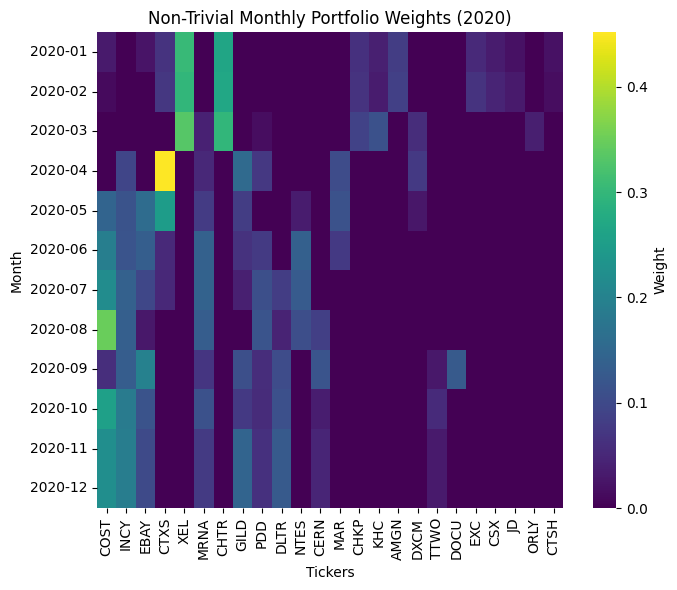

In [ ]:
# === Heatmap of weights (months × tickers) ===

# Pick which weights table to visualize:
W = nontrivial_weights_df.copy()   # or weights_df if you want *all* columns

# Optional: sort tickers by average weight across 2020 for a cleaner view
col_order = W.mean(axis=0).sort_values(ascending=False).index
W = W[col_order]

plt.figure(figsize=(min(24, 1 + 0.25*W.shape[1]), 6))  # adjust width dynamically
ax = sns.heatmap(
    W,
    cmap="viridis",
    linewidths=0.0,
    cbar_kws={"label": "Weight"},
    annot=False
)
ax.set_title("Non-Trivial Monthly Portfolio Weights (2020)")
ax.set_xlabel("Tickers")
ax.set_ylabel("Month")
plt.tight_layout()
plt.show()


### Part 5 evaluation:  Using this method, there is some reduction in average out-of-sample CVaR (down to 3.2% from 4.6%), but given the nature of 2020 in hindsight, it's clear there was much more volatility in the market that we can't necessarily fully control for in this model (as shown in min/max comparisons for in and out-of-sample CVaR).  

### Also, our portfolio performed well (45.1% return), the NDX index 44.8% over that same time, so in terms of returns, it could be that most of that performance is intrinsic to the market, not to the extra effort we're going to.  Additional factors like trading fees and short-term capital gains taxes would have to be factored in to see if it's worth it from that perspective.  

### It would also be useful to back test this method on years the market was down to see if losses were controlled during those years

## Part 6

### Mask for months that have > 5% change in weight for any one instrument (9 out of 12 months)

In [ ]:
# Absolute change in weights month to month
weight_changes = weights_df.diff().abs()

# Flag any changes > 0.05
unstable_flags = (weight_changes > 0.05)

# Which months have at least one instrument unstable?
unstable_months = unstable_flags.any(axis=1)

# uncomment to see all weight changes
# display(weight_changes.round(4))

display(unstable_months)


,0
Month,
2020-01,False
2020-02,False
2020-03,True
2020-04,True
2020-05,True
2020-06,True
2020-07,True
2020-08,True
2020-09,True


### Specific instruments that changed > 5% during those months

In [ ]:
breaches = (weights_df.diff().abs() > 0.05)
violators_by_month = {
    m: list(row[row].index) for m, row in breaches.iterrows() if row.any()
}
pd.Series(violators_by_month, name="Tickers > 5% change")


,Tickers > 5% change
2020-03,"[AMGN, CTXS, DXCM, EXC, KHC]"
2020-04,"[CHTR, CHKP, CTXS, GILD, INCY, KHC, MAR, PDD, ..."
2020-05,"[CTXS, COST, EBAY, GILD, PDD]"
2020-06,"[CTXS, MRNA, NTES, PDD]"
2020-07,"[DLTR, MAR]"
2020-08,"[CERN, CTXS, COST, EBAY]"
2020-09,"[COST, DOCU, DLTR, EBAY, GILD, MRNA, NTES, PDD]"
2020-10,"[CERN, COST, DOCU, EBAY, INCY]"
2020-11,[GILD]


### Part 6 evaluation:  There's really only a few levers to pull on to keep stock weights from adjusting more than 5% in any given month.
1. Add that % change as a constraint.  This is probably the only way to guarantee no such change occurs.
2. You could induce a turnover penalty or a kind of turnover budget for the entire portfolio, but these are kind of "softer" controls.
3. Other factors such as risk appetite (beta), return floor, or the frequency of rebalance may indirectly affect turnover, but there's no assurance of that.
4. Setting strict weight limits is possible, but again, not a sure-thing.
5. Allowing shorts or applying leverage (weights > 1.0) are also unlikely to make the portfolio more stable.

### For all of these things, it's not clear without running simulations whether that would improve CVaR and returns performance, or simply add artificial limitations